Loading the dataset...

Dataset Shape: (541909, 8)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Summary Statistics:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



Missing Values Count:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Starting data cleaning...
Rows after removing missing CustomerID: 406829 (removed 135080 rows)
Rows after removing negative/zero quantities: 397924
Rows after removing negative/zero unit prices: 397884
Rows after removing TotalPrice outliers: 366643 (removed 31241 rows)
Rows after removing cancelled orders: 366643 (removed 0 rows)


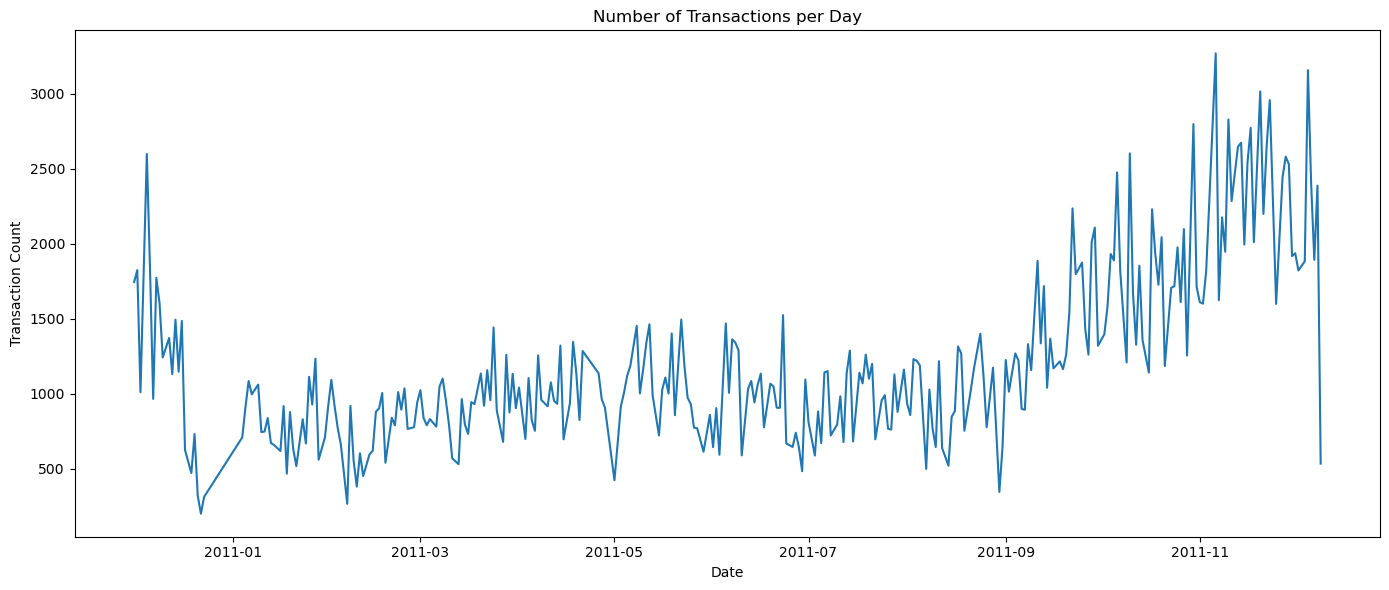

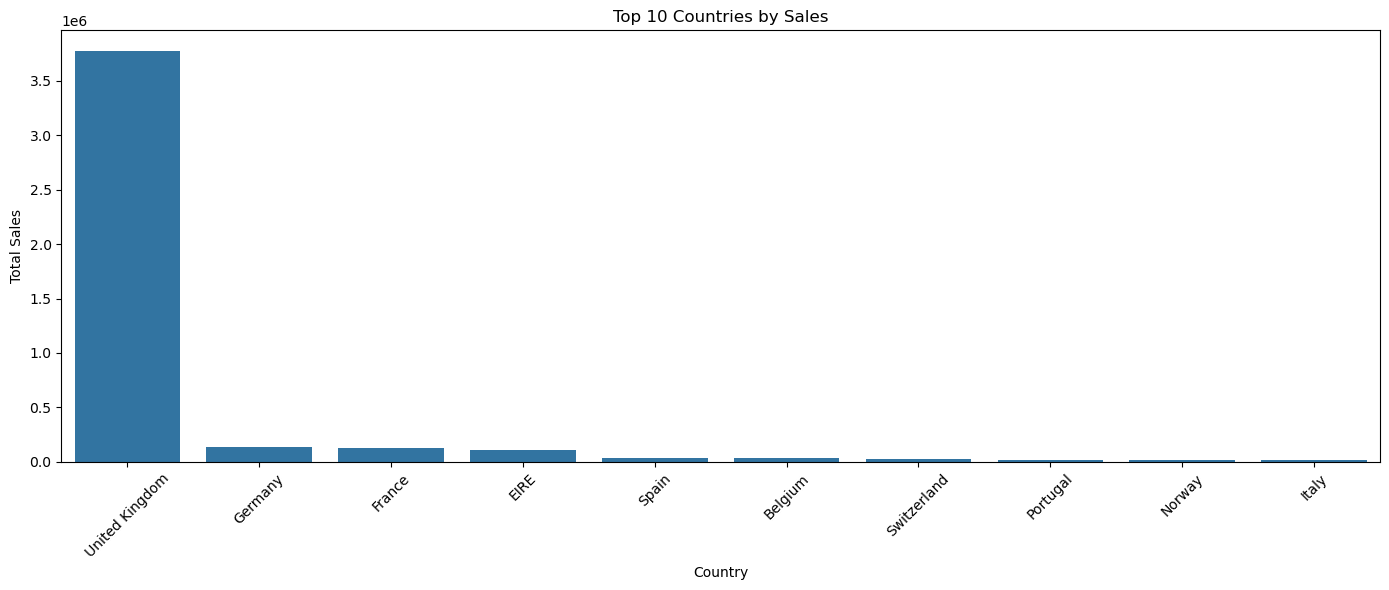

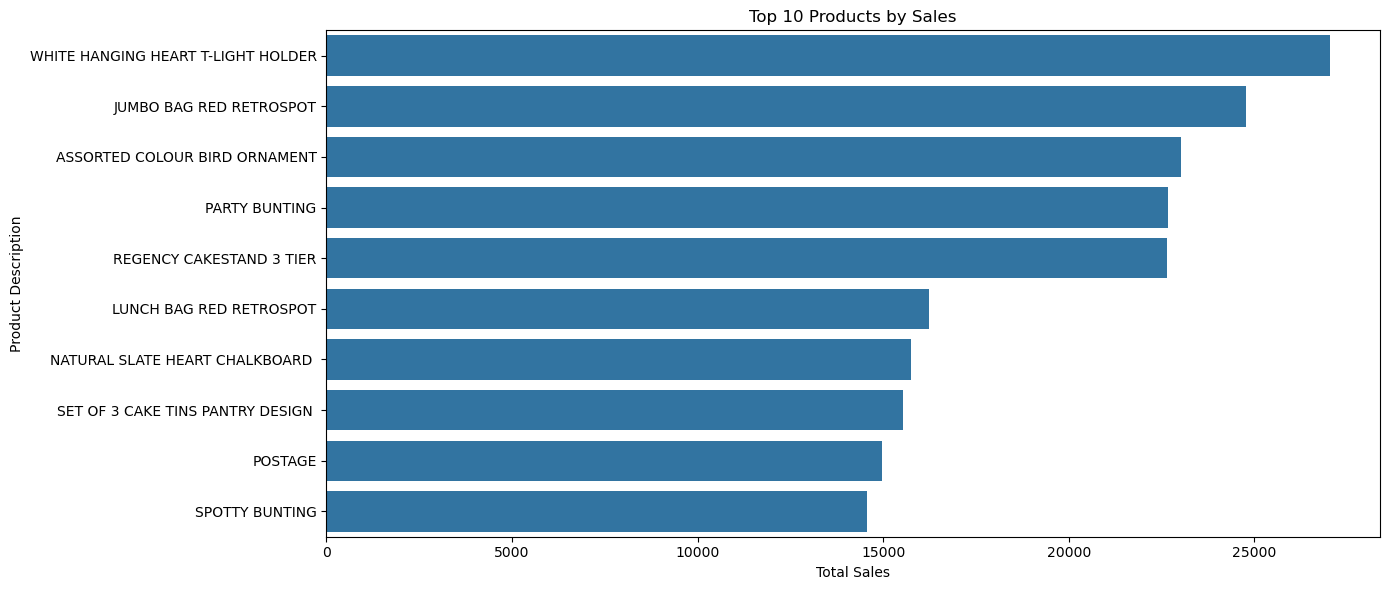

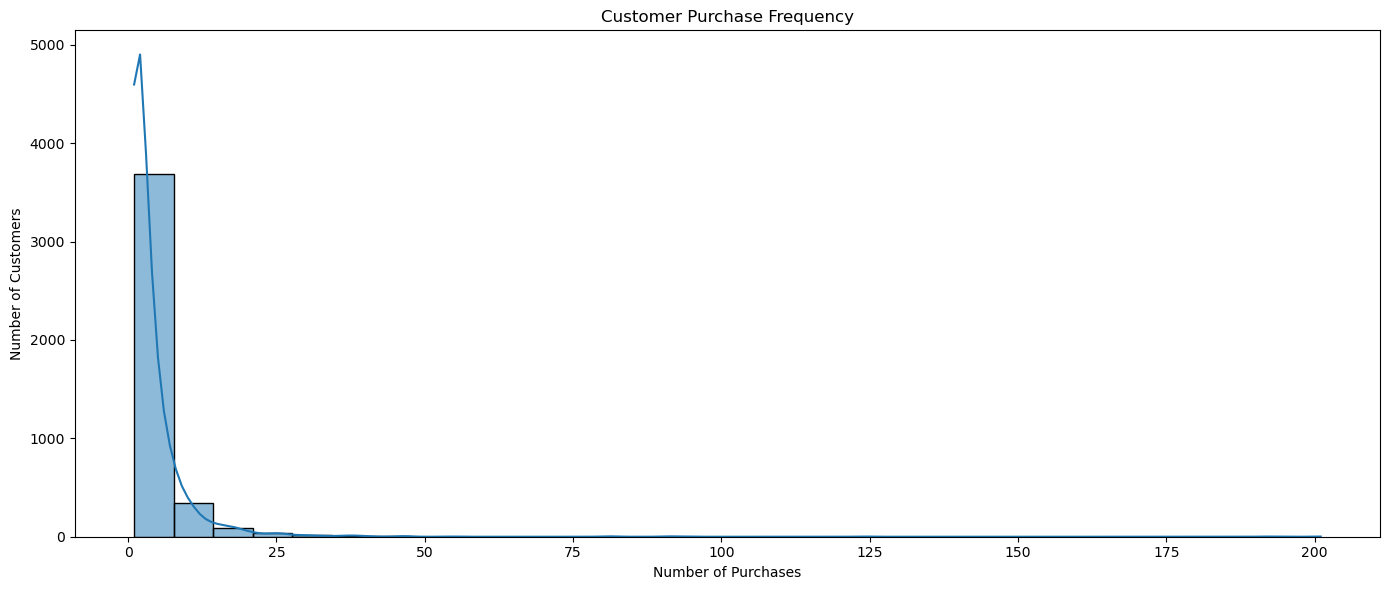


Reference date for RFM calculation: 2011-12-10 12:50:00

RFM Features:


,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,3174.62
12348,75,4,601.64
12349,19,1,1145.35
12350,310,1,334.40
12352,36,7,1505.74


RFM shape: (4194, 3)

Saving cleaned data and RFM features...

Data cleaning completed!

Customer profile saved to '../1_Data/processed/customer_profile.csv'

Customer Profile Features:


,CustomerID,AvgOrderValue,PurchaseVariability,DaysSinceFirstPurchase,AvgDaysBetweenPurchases,UniqueProducts,Recency,Frequency,Monetary
0,12347,0.0,0.0,0.0,0.0,0.0,2,7,3174.62
1,12348,0.0,0.0,0.0,0.0,0.0,75,4,601.64
2,12349,0.0,0.0,0.0,0.0,0.0,19,1,1145.35
3,12350,0.0,0.0,0.0,0.0,0.0,310,1,334.40
4,12352,0.0,0.0,0.0,0.0,0.0,36,7,1505.74


Customer Profile shape: (4194, 9)


In [1]:
# Customer Retention Project - Data Cleaning
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs('../1_Data/processed', exist_ok=True)
os.makedirs('../1_Data/outputs', exist_ok=True)

# 1. Load the dataset
print("Loading the dataset...")
df = pd.read_csv('../1_Data/raw/OnlineRetail.csv', encoding='ISO-8859-1')

# 2. Display basic information
print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

print("\nDataset Info:")
df.info()

print("\nSummary Statistics:")
display(df.describe())

# 3. Check for missing values
print("\nMissing Values Count:")
print(df.isnull().sum())

# 4. Data Cleaning
print("\nStarting data cleaning...")

# 4.1. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

# 4.2. Filter out records with missing CustomerID
df_cleaned = df.dropna(subset=['CustomerID'])
print(f"Rows after removing missing CustomerID: {df_cleaned.shape[0]} (removed {df.shape[0] - df_cleaned.shape[0]} rows)")

# 4.3. Convert CustomerID to integer
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

# 4.4. Filter out records with quantity less than or equal to 0
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
print(f"Rows after removing negative/zero quantities: {df_cleaned.shape[0]}")

# 4.5. Filter out records with unit price less than or equal to 0
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]
print(f"Rows after removing negative/zero unit prices: {df_cleaned.shape[0]}")

# 4.6. Create TotalPrice column
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# 4.7. Identify and remove outliers (optional)
# We'll use IQR method for TotalPrice
Q1 = df_cleaned['TotalPrice'].quantile(0.25)
Q3 = df_cleaned['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df_cleaned[~((df_cleaned['TotalPrice'] < (Q1 - 1.5 * IQR)) | 
                              (df_cleaned['TotalPrice'] > (Q3 + 1.5 * IQR)))]

print(f"Rows after removing TotalPrice outliers: {df_no_outliers.shape[0]} (removed {df_cleaned.shape[0] - df_no_outliers.shape[0]} rows)")

# 4.8. Filter out cancelled orders (those starting with 'C')
df_no_cancelled = df_no_outliers[~df_no_outliers['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Rows after removing cancelled orders: {df_no_cancelled.shape[0]} (removed {df_no_outliers.shape[0] - df_no_cancelled.shape[0]} rows)")

# 5. Exploratory Data Analysis

# 5.1. Transaction distribution over time
plt.figure(figsize=(14, 6))
df_no_cancelled['InvoiceDate'].dt.date.value_counts().sort_index().plot()
plt.title('Number of Transactions per Day')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.tight_layout()
plt.show()

# 5.2. Sales by country
plt.figure(figsize=(14, 6))
country_sales = df_no_cancelled.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=country_sales.index, y=country_sales.values)
plt.title('Top 10 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.3. Top products by sales
top_products = df_no_cancelled.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

# 5.4. Customer purchase frequency
customer_purchase_frequency = df_no_cancelled.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(14, 6))
sns.histplot(customer_purchase_frequency, bins=30, kde=True)
plt.title('Customer Purchase Frequency')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# 6. RFM Features Calculation

# Calculate the most recent date in the dataset to use as reference for recency
max_date = df_no_cancelled['InvoiceDate'].max() + timedelta(days=1)
print(f"\nReference date for RFM calculation: {max_date}")

# Group by CustomerID and calculate RFM metrics
rfm = df_no_cancelled.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                             # Frequency
    'TotalPrice': 'sum'                                # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM dataframe
print("\nRFM Features:")
display(rfm.head())
print(f"RFM shape: {rfm.shape}")

# 7. Save cleaned data and RFM features
print("\nSaving cleaned data and RFM features...")
df_no_cancelled.to_csv('../1_Data/processed/cleaned_data.csv', index=False)
rfm.to_csv('../1_Data/processed/rfm_features.csv')

print("\nData cleaning completed!")

# Additional customer metrics (useful for segmentation and prediction)

# 7.1. Create customer profile dataframe
customer_profile = pd.DataFrame()
customer_profile['CustomerID'] = rfm.index

# 7.2. Average order value
customer_profile['AvgOrderValue'] = df_no_cancelled.groupby('CustomerID')['TotalPrice'].mean()

# 7.3. Purchase variability (standard deviation of order values)
customer_profile['PurchaseVariability'] = df_no_cancelled.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index().groupby('CustomerID')['TotalPrice'].std()

# 7.4. Days since first purchase
customer_profile['DaysSinceFirstPurchase'] = df_no_cancelled.groupby('CustomerID')['InvoiceDate'].min().apply(lambda x: (max_date - x).days)

# 7.5. Average days between purchases
def avg_days_between_purchases(purchase_dates):
    if len(purchase_dates) <= 1:
        return 0
    purchase_dates = sorted(purchase_dates)
    return np.mean([(purchase_dates[i+1] - purchase_dates[i]).days for i in range(len(purchase_dates)-1)])

customer_profile['AvgDaysBetweenPurchases'] = df_no_cancelled.groupby('CustomerID')['InvoiceDate'].agg(lambda x: avg_days_between_purchases(list(x)))

# 7.6. Number of unique products purchased
customer_profile['UniqueProducts'] = df_no_cancelled.groupby('CustomerID')['StockCode'].nunique()

# 7.7. Merge with RFM metrics
customer_profile = customer_profile.merge(rfm, on='CustomerID')

# 7.8. Fill NaN values
customer_profile.fillna(0, inplace=True)

# 7.9. Save customer profile
customer_profile.to_csv('../1_Data/processed/customer_profile.csv', index=False)
print("\nCustomer profile saved to '../1_Data/processed/customer_profile.csv'")

# Display customer profile
print("\nCustomer Profile Features:")
display(customer_profile.head())
print(f"Customer Profile shape: {customer_profile.shape}")